<a href="https://colab.research.google.com/github/vi-shruti/Kaggle/blob/master/RevenuePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

What should I expect the data format to be?
Both train_v2.csv and test_v2.csv contain the columns listed under Data Fields. Each row in the dataset is one visit to the store. Because we are predicting the log of the total revenue per user, be aware that not all rows in test_v2.csv will correspond to a row in the submission, but all unique fullVisitorIds will correspond to a row in the submission.

What am I predicting?
We are predicting the natural log of the sum of all transactions per user. Once the data is updated, as noted above, this will be for all users in test_v2.csv for December 1st, 2018 to January 31st, 2019. For every user in the test set, the target is:
yuser=∑i=1ntransactionuseri
targetuser=ln(yuser+1)
Note that the dataset does NOT contain data for December 1st 2018 to January 31st 2019. You must identify the unique fullVisitorIds in the provided test_v2.csv and make predictions for them for those unseen months.

File Descriptions
train.csv - the old training set - contains the same data as the BigQuery rstudio_train_set. Contains user transactions from August 1st 2016 to August 1st 2017.
test.csv - the old test set - contains the same data as the BigQuery rstudio_test_set. Contains user transactions from August 2nd 2017 to April 30th 2018.
sampleSubmission.csv - the old sample submission file in the correct format. Contains all fullVisitorIds in test.csv.

train_v2.csv - the updated training set - contains user transactions from August 1st 2016 to April 30th 2018.

test_v2.csv - the updated test set - contains user transactions from May 1st 2018 to October 15th 2018.
sample_submission_v2.csv - a updated sample submission file in the correct format. Contains all fullVisitorIds in test_v2.csv. Your submission's PredictedLogRevenue column should make forward-looking predictions for each of these fullVisitorIds for the timeframe of December 1st 2018 to January 31st 2019. Review "What am I predicting?" above for details.
Data Fields
fullVisitorId- A unique identifier for each user of the Google Merchandise Store.
channelGrouping - The channel via which the user came to the Store.
date - The date on which the user visited the Store.
device - The specifications for the device used to access the Store.
geoNetwork - This section contains information about the geography of the user.
sessionId - A unique identifier for this visit to the store.
socialEngagementType - Engagement type, either "Socially Engaged" or "Not Socially Engaged".
totals - This section contains aggregate values across the session.
trafficSource - This section contains information about the Traffic Source from which the session originated.
visitId - An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.
visitNumber - The session number for this user. If this is the first session, then this is set to 1.
visitStartTime - The timestamp (expressed as POSIX time).
Removed Data Fields
Some fields were censored to remove target leakage. The major censored fields are listed below.

hits - This row and nested fields are populated for any and all types of hits. Provides a record of all page visits.
customDimensions - This section contains any user-level or session-level custom dimensions that are set for a session. This is a repeated field and has an entry for each dimension that is set.
totals - Multiple sub-columns were removed from the totals field.
External Data
External data is permitted for this competition, per this forum post. This includes the Google Merchandise Store Demo Account. Although the Demo Account contains the predicted variable, final standings will not benefit from access to this external data, because it requires future-looking predictions.



In [2]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics
!pip install lightgbm
import lightgbm as lgb

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
os.chdir("/content/drive/My Drive")
#!ls "/content/drive/My Drive"

In [0]:
def load_df(csv_path, nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column].tolist())
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

In [6]:
%%time
train_df = load_df("../My Drive/train.csv")
test_df = load_df("../My Drive/test.csv")

Loaded train.csv. Shape: (903653, 55)
Loaded test.csv. Shape: (804684, 53)
CPU times: user 2min 47s, sys: 16.9 s, total: 3min 4s
Wall time: 4min 56s


In [7]:
train_df.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,device.browserVersion,device.deviceCategory,device.flashVersion,device.isMobile,device.language,device.mobileDeviceBranding,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.mobileDeviceModel,device.mobileInputSelector,device.operatingSystem,device.operatingSystemVersion,device.screenColors,device.screenResolution,geoNetwork.city,geoNetwork.cityId,geoNetwork.continent,geoNetwork.country,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.networkLocation,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,totals.visits,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Izmir,not available in demo dataset,Asia,Turkey,not available in demo dataset,not available in demo dataset,(not set),ttnet.com.tr,not available in demo dataset,Izmir,Western Asia,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Oceania,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,Australasia,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Madrid,not available in demo dataset,Europe,Spain,not available in demo dataset,not available in demo dataset,(not set),unknown.unknown,not available in demo dataset,Community of Madrid,Southern Europe,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not a

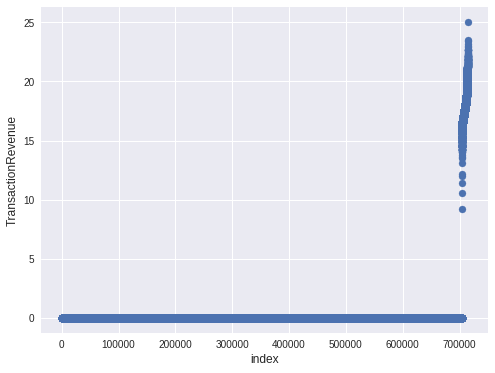

In [8]:
train_df["totals.transactionRevenue"] = train_df["totals.transactionRevenue"].astype('float')
gdf = train_df.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()

plt.figure(figsize=(8,6))
plt.scatter(range(gdf.shape[0]), np.sort(np.log1p(gdf["totals.transactionRevenue"].values)))
plt.xlabel('index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.show()

In [0]:
df = df.join(df['device'].apply(json.loads).apply(pd.Series))
df = df.join(df['geoNetwork'].apply(json.loads).apply(pd.Series))
df = df.join(df['totals'].apply(json.loads).apply(pd.Series))
df = df.join(df['trafficSource'].apply(json.loads).apply(pd.Series))
print(df.tail())

In [0]:
list(df)

Full column list:
'channelGrouping',
 'date',
 'device',
 'fullVisitorId',
 'geoNetwork',
 'sessionId',
 'socialEngagementType',
 'totals',
 'trafficSource',
 'visitId',
 'visitNumber',
 'visitStartTime',
 'browser',
 'browserSize',
 'browserVersion',
 'deviceCategory',
 'flashVersion',
 'isMobile',
 'language',
 'mobileDeviceBranding',
 'mobileDeviceInfo',
 'mobileDeviceMarketingName',
 'mobileDeviceModel',
 'mobileInputSelector',
 'operatingSystem',
 'operatingSystemVersion',
 'screenColors',
 'screenResolution',
 'city',
 'cityId',
 'continent',
 'country',
 'latitude',
 'longitude',
 'metro',
 'networkDomain',
 'networkLocation',
 'region',
 'subContinent',
 'bounces',
 'hits',
 'newVisits',
 'pageviews',
 'transactionRevenue',
 'visits',
 'adContent',
 'adwordsClickInfo',
 'campaign',
 'campaignCode',
 'isTrueDirect',
 'keyword',
 'medium',
 'referralPath',
 'source'

In [0]:
columns = ['device', 'geoNetwork', 'totals', 'trafficSource']
df.drop(columns, inplace=True, axis=1)
print(df.head())

  channelGrouping      date        fullVisitorId                       sessionId  socialEngagementType     visitId  visitNumber  visitStartTime     browser                    browserSize                 browserVersion deviceCategory                   flashVersion  isMobile                       language           mobileDeviceBranding               mobileDeviceInfo      mobileDeviceMarketingName              mobileDeviceModel            mobileInputSelector operatingSystem         operatingSystemVersion                   screenColors               screenResolution                           city                         cityId continent         country                       latitude                      longitude                          metro    networkDomain                networkLocation                         region     subContinent bounces hits newVisits pageviews transactionRevenue visits adContent                                   adwordsClickInfo   campaign campaignCode  \
0  Orga

In [0]:
#s1 = json.dumps(df)
#df_sub = json.loads(s1)
#df = df.join(df['adwordsClickInfo'].apply(json.dumps).apply(pd.Series))
#print(df.tail())

In [0]:
#df.drop('0', inplace=True, axis=1)
#df = df.iloc[,:-1]
#print(df.head())

In [0]:
"""#import urllib2
import json  
#data = urllib2.urlopen(df['adwordsClickInfo']).read()
data = json.loads(df['adwordsClickInfo'])
row = -1
for i in df['adwordsClickInfo']:
    row = row + 1
    #data = urllib2.urlopen(str(i)).read()
    data = json.loads(data)
    for key in data.keys():
        print(data[key])
        #df.loc[row,key] = data[key]"""

In [0]:
#df.dtypes

In [0]:
"""import ast
import json
#test = df['adwordsClickInfo'].astype('|S')
#response_item = ast.literal_eval(json.dumps(response_item, ensure_ascii=False).encode('utf8'))
test = json.dumps(ast.literal_eval(df['adwordsClickInfo']).encode('utf8'), ensure_ascii=False)
#test = ast.literal_eval(json.dumps(df['adwordsClickInfo'], ensure_ascii=False).encode('utf8'))
#df = df.join(df['adwordsClickInfo'].apply(json.loads).apply(pd.Series))
test = df.join(test.apply(json.loads).apply(pd.Series))
print(test.head())
test.dtypes"""

TypeError: ignored